In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error,make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import plot_importance
from sklearn.preprocessing import StandardScaler




x_train = pd.read_csv('X_train_NHkHMNU.csv')
y_train = pd.read_csv('y_train_ZAN5mwg.csv')
x_test =  pd.read_csv('X_test_final.csv')

pd.set_option('display.max_columns', None)
from sklearn.impute import KNNImputer


In [3]:
def preprocessing(dataset):

    dataset = pd.get_dummies(dataset, columns=['COUNTRY'])
    placeholder_value = -9999
    dataset_filled = dataset.fillna(placeholder_value)
    columns_to_impute = dataset_filled.columns
    imputer = KNNImputer(n_neighbors=5)
    dataset_filled.replace(placeholder_value, float('nan'), inplace=True)
    return pd.DataFrame(imputer.fit_transform(dataset_filled), columns=columns_to_impute)

def scale_features_exclude_id(dataset, id_column):
    # Extract the ID column and save it
    ids = dataset[id_column]
    
    # Drop the ID column before scaling
    dataset_to_scale = dataset.drop(id_column, axis=1)
    
    # Initialize the StandardScaler
    scaler = StandardScaler()
    
    # Fit and transform the data without the ID column
    scaled_data = scaler.fit_transform(dataset_to_scale)
    
    # Create a DataFrame from the scaled data
    scaled_df = pd.DataFrame(scaled_data, columns=dataset_to_scale.columns)
    
    # Reinsert the ID column
    scaled_df[id_column] = ids.values
    
    # Reorder columns to place ID column at its original location
    columns = [id_column] + [col for col in scaled_df.columns if col != id_column]
    scaled_df = scaled_df[columns]
    
    return scaled_df

x_train_imputed = preprocessing(x_train)
x_test_imputed = preprocessing(x_test)

x_train_imputed['DE_GAS_COAL_INTERACTION'] = x_train_imputed['DE_GAS'] * x_train_imputed['DE_COAL']
x_train_imputed['DE_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_NET_EXPORT'].cumsum()
x_train_imputed['FR_NET_EXPORT_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_NET_EXPORT'].cumsum()
x_train_imputed['FR_CONSUMPTION_cumsum'] = x_train_imputed.groupby('DAY_ID')['FR_CONSUMPTION'].cumsum()
x_train_imputed['DE_CONSUMPTION_cumsum'] = x_train_imputed.groupby('DAY_ID')['DE_CONSUMPTION'].cumsum()
x_test_imputed['GAS_COAL_INTERACTION'] = x_test_imputed['DE_GAS'] * x_test_imputed['DE_COAL']

x_train_imputed = scale_features_exclude_id(x_train_imputed, 'DAY_ID')
x_test_imputed = scale_features_exclude_id(x_test_imputed, 'DAY_ID')

In [4]:
x_train_imputed.head()

,DAY_ID,ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,DE_GAS_COAL_INTERACTION,DE_NET_EXPORT_cumsum,FR_NET_EXPORT_cumsum,FR_CONSUMPTION_cumsum,DE_CONSUMPTION_cumsum
0,206.0,-0.030364,-0.322857,-0.443488,-0.485207,0.485207,1.071028,0.723596,-1.071028,-0.723596,-0.399410,-0.671802,1.033005,1.429527,1.539319,0.096641,1.305529,0.265854,-0.135517,0.593795,-0.676524,-0.561718,1.373826,0.652048,-0.324738,-0.145675,-0.572836,-0.880001,-0.411341,-1.113070,-0.053275,0.255982,0.060791,-0.075534,-0.869242,0.869242,0.135522,0.800184,0.503731,-0.270405,-0.367669
1,501.0,1.580173,-0.668227,-1.070463,0.121136,-0.121136,-0.379181,-0.985283,0.379181,0.985283,-0.712934,0.035225,-0.042576,-0.647535,-0.321772,-0.863111,-1.567949,-1.803692,1.627541,2.436614,-0.170940,-0.425377,0.122845,-0.548748,-1.148970,-1.260002,-0.781465,1.349790,0.665097,0.472314,1.881258,-0.653560,-0.014136,-0.519802,-0.869242,0.869242,-0.177892,-0.150114,-0.608582,-0.693418,-0.592145
2,687.0,1.377844,1.437334,2.175600,1.203569,-1.203569,-0.430784,-1.502294,0.430784,1.502294,1.848693,1.906013,2.014869,2.394545,-0.594840,0.636875,-1.583876,1.225802,-1.273716,-0.907498,-0.418386,-0.453879,0.854386,1.486102,2.344758,-0.467172,-0.336031,0.297919,0.335065,0.732739,0.128718,0.435437,0.659515,0.113308,-0.869242,0.869242,3.098533,-0.183928,-0.945106,1.496668,0.776382
3,720.0,-1.255667,-2.095654,-0.902555,-0.726996,0.726996,-0.057185,0.602128,0.057185,-0.602128,-0.344604,-0.221100,-1.581446,-0.694716,-0.834109,1.148775,0.291125,-1.185154,1.406974,-0.041927,-0.147041,-0.026527,-2.387277,-1.484376,-0.918821,-1.129052,-0.525298,-0.599089,-0.365912,0.381304,-0.414841,0.777771,-0.346290,0.904558,1.150428,-1.150428,-0.783649,0.060885,0.424667,-0.580133,-1.519913
4,818.0,0.045712,-0.421331,-0.649847,-0.815597,0.815597,0.733009,1.002332,-0.733009,-1.002332,-0.637725,-0.701703,1.343639,0.315321,-0.706815,-0.852588,0.512776,0.646885,0.417783,0.106950,-0.866000,-0.809856,1.163141,0.587372,-0.415813,-0.530595,-0.444400,-1.166620,-1.116718,0.658499,0.756317,0.170387,1.417389,2.307172,-0.869242,0.869242,0.058869,0.578686,0.685161,-0.409633,-0.431673


In [5]:
x_train_imputed.drop('ID', axis = 1, inplace = True)

y_train.drop('ID', axis = 1, inplace = True)


In [6]:
x_train_imputed.head()

,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,COUNTRY_DE,COUNTRY_FR,DE_GAS_COAL_INTERACTION,DE_NET_EXPORT_cumsum,FR_NET_EXPORT_cumsum,FR_CONSUMPTION_cumsum,DE_CONSUMPTION_cumsum
0,206.0,-0.322857,-0.443488,-0.485207,0.485207,1.071028,0.723596,-1.071028,-0.723596,-0.399410,-0.671802,1.033005,1.429527,1.539319,0.096641,1.305529,0.265854,-0.135517,0.593795,-0.676524,-0.561718,1.373826,0.652048,-0.324738,-0.145675,-0.572836,-0.880001,-0.411341,-1.113070,-0.053275,0.255982,0.060791,-0.075534,-0.869242,0.869242,0.135522,0.800184,0.503731,-0.270405,-0.367669
1,501.0,-0.668227,-1.070463,0.121136,-0.121136,-0.379181,-0.985283,0.379181,0.985283,-0.712934,0.035225,-0.042576,-0.647535,-0.321772,-0.863111,-1.567949,-1.803692,1.627541,2.436614,-0.170940,-0.425377,0.122845,-0.548748,-1.148970,-1.260002,-0.781465,1.349790,0.665097,0.472314,1.881258,-0.653560,-0.014136,-0.519802,-0.869242,0.869242,-0.177892,-0.150114,-0.608582,-0.693418,-0.592145
2,687.0,1.437334,2.175600,1.203569,-1.203569,-0.430784,-1.502294,0.430784,1.502294,1.848693,1.906013,2.014869,2.394545,-0.594840,0.636875,-1.583876,1.225802,-1.273716,-0.907498,-0.418386,-0.453879,0.854386,1.486102,2.344758,-0.467172,-0.336031,0.297919,0.335065,0.732739,0.128718,0.435437,0.659515,0.113308,-0.869242,0.869242,3.098533,-0.183928,-0.945106,1.496668,0.776382
3,720.0,-2.095654,-0.902555,-0.726996,0.726996,-0.057185,0.602128,0.057185,-0.602128,-0.344604,-0.221100,-1.581446,-0.694716,-0.834109,1.148775,0.291125,-1.185154,1.406974,-0.041927,-0.147041,-0.026527,-2.387277,-1.484376,-0.918821,-1.129052,-0.525298,-0.599089,-0.365912,0.381304,-0.414841,0.777771,-0.346290,0.904558,1.150428,-1.150428,-0.783649,0.060885,0.424667,-0.580133,-1.519913
4,818.0,-0.421331,-0.649847,-0.815597,0.815597,0.733009,1.002332,-0.733009,-1.002332,-0.637725,-0.701703,1.343639,0.315321,-0.706815,-0.852588,0.512776,0.646885,0.417783,0.106950,-0.866000,-0.809856,1.163141,0.587372,-0.415813,-0.530595,-0.444400,-1.166620,-1.116718,0.658499,0.756317,0.170387,1.417389,2.307172,-0.869242,0.869242,0.058869,0.578686,0.685161,-0.409633,-0.431673


In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize the DecisionTreeRegressor with a random state for reproducibility
dt_reg = DecisionTreeRegressor(random_state=42)

# Compute the cross-validated MSE
mse_valid_dt = cross_val_score(dt_reg, x_train_imputed, y_train, scoring='neg_mean_squared_error', cv=5)
average_mse_dt = -np.mean(mse_valid_dt)
print(f'Average MSE for Decision Tree: {average_mse_dt}')

# Compute the cross-validated MAE
mae_scores_dt = cross_val_score(dt_reg, x_train_imputed, y_train, scoring='neg_mean_absolute_error', cv=5)
average_mae_dt = -np.mean(mae_scores_dt)
print(f'Average MAE for Decision Tree: {average_mae_dt}')


Average MSE for Decision Tree: 2.1104887338261342
Average MAE for Decision Tree: 0.8951678653539805


In [9]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

# Initialize the DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)

# Fit the model to your data
dt_reg.fit(x_train_imputed, y_train)

# Get feature importances
feature_importances = dt_reg.feature_importances_

# Get the feature names
feature_names = x_train_imputed.columns.tolist()

sorted_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

# Create a DataFrame to hold feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Reset the index of the DataFrame
feature_importance_df.reset_index(drop=True, inplace=True)

print("Feature Importances (Sorted):")
print(feature_importance_df)


Feature Importances (Sorted):
                    Feature  Importance
0                DE_WINDPOW    0.084994
1                   GAS_RET    0.073196
2     FR_CONSUMPTION_cumsum    0.067548
3                    DAY_ID    0.064146
4                  FR_SOLAR    0.053759
5            DE_CONSUMPTION    0.044703
6                  DE_SOLAR    0.042946
7                    DE_GAS    0.042227
8                FR_WINDPOW    0.034956
9      DE_NET_EXPORT_cumsum    0.031747
10               CARBON_RET    0.030869
11     FR_NET_EXPORT_cumsum    0.028661
12    DE_CONSUMPTION_cumsum    0.026487
13                   FR_GAS    0.024100
14                 DE_HYDRO    0.023917
15                  FR_COAL    0.021310
16                 FR_HYDRO    0.020904
17                  FR_WIND    0.020236
18                  FR_RAIN    0.019963
19                  DE_WIND    0.018182
20           FR_CONSUMPTION    0.016685
21                  DE_RAIN    0.016005
22               DE_NUCLEAR    0.015710
23        

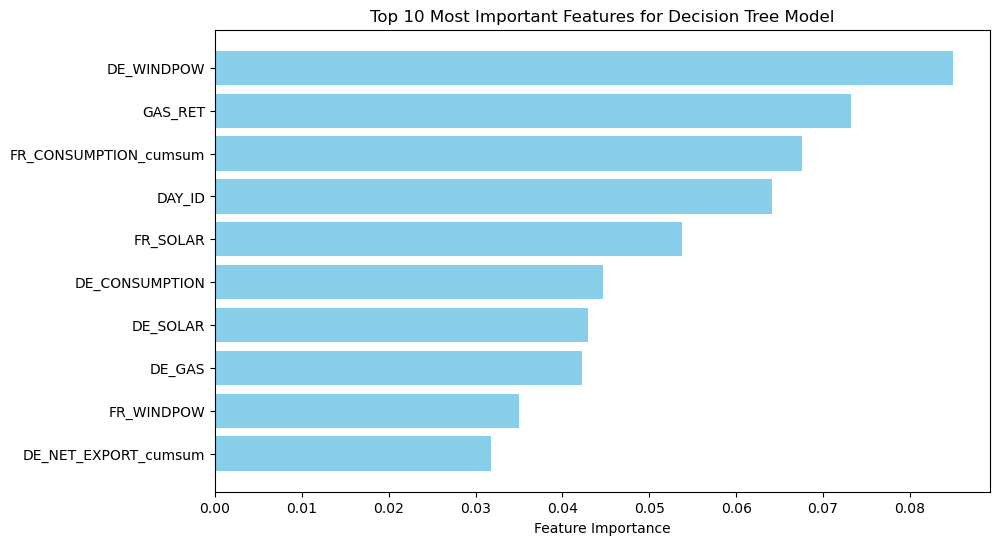

In [10]:
import matplotlib.pyplot as plt

# Assuming 'feature_importance_df' is your DataFrame with feature importances sorted in descending order
top_10_features = feature_importance_df.head(10)

# Create a horizontal bar chart for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features for Decision Tree Model')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


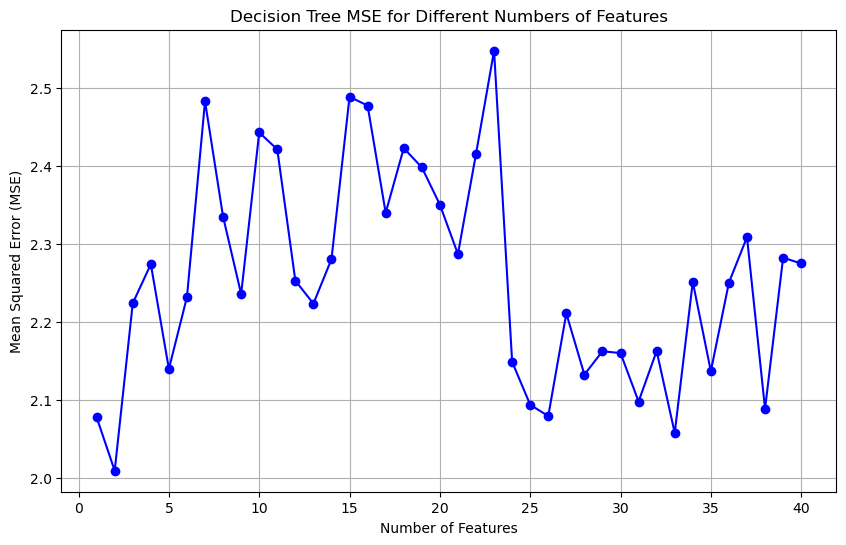

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_train_imputed is already defined and contains the imputed training data

# Initialize an empty list to store the mean squared errors for each k number of features
mse_scores_per_k = []

# Initialize the DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)

# Loop over the range of number of features
for k in range(1, len(x_train_imputed.columns) + 1):
    # Select the top k features based on previously computed feature importances
    selected_features = [feature[0] for feature in sorted_importances[:k]]
    
    # Compute the cross-validated MSE
    mse_scores = cross_val_score(dt_reg, x_train_imputed[selected_features], y_train, scoring='neg_mean_squared_error', cv=5)
    mse_scores_per_k.append(-np.mean(mse_scores))

# Plot the MSE scores for each number of top features used
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(x_train_imputed.columns) + 1), mse_scores_per_k, marker='o', linestyle='-', color='b')
plt.title('Decision Tree MSE for Different Numbers of Features')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()



In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter grid specific to DecisionTreeRegressor
param_grid_dt = {
    'max_depth': [None] + list(range(1, 20)),  # None means no limit on depth
    'min_samples_split': range(2, 20),
    'min_samples_leaf': range(1, 20),
    'max_features': ['sqrt', 'log2', None]  # None means max_features=n_features
}

# Initialize the DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)

# Setup RandomizedSearchCV for DecisionTreeRegressor
random_search_dt = RandomizedSearchCV(
    dt_reg,
    param_distributions=param_grid_dt,
    n_iter=80,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV
random_search_dt.fit(x_train_imputed, y_train)

# Print the best parameters and the mean cross-validated score of the best estimator
print("Best Parameters:", random_search_dt.best_params_)
best_dt_model = random_search_dt.best_estimator_
mean_cv_score_dt = random_search_dt.best_score_
print(f'Mean Cross-Validated Score: {-mean_cv_score_dt}')

Best Parameters: {'min_samples_split': 4, 'min_samples_leaf': 13, 'max_features': 'log2', 'max_depth': 2}
Mean Cross-Validated Score: 1.0524764277366156


In [15]:
rs_df = pd.DataFrame(random_search_dt.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,split2_test_score,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,4,13,log2,2,-0.801969,-1.146295,-0.849548,-1.052476,1
1,5,3,log2,2,-0.802007,-1.146295,-0.849548,-1.060409,2
2,12,8,log2,3,-0.813511,-1.138368,-0.907891,-1.070547,3
3,3,13,log2,1,-0.832629,-1.121540,-0.865330,-1.072614,4
4,13,18,log2,1,-0.832629,-1.121540,-0.865330,-1.072614,4
5,11,11,None,1,-0.813008,-1.151674,-0.885216,-1.079267,6
6,9,14,sqrt,1,-0.862712,-1.133183,-0.865330,-1.081515,7
7,19,15,None,2,-0.812260,-1.209195,-0.898844,-1.095444,8
8,7,12,log2,5,-0.864858,-1.195831,-0.962586,-1.110951,9
9,3,11,None,3,-0.861080,-1.227291,-0.921772,-1.117896,10


In [22]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict
from scipy.stats import spearmanr

# Assuming sorted_importances and x_train_imputed are defined as before
# and y_train is your target variable.

# Initialize the DecisionTreeRegressor
dt_reg_selected = DecisionTreeRegressor(random_state=42)

# Extract the top 8 features based on sorted importances from a previous model 
selected_features = [feature[0] for feature in sorted_importances[:9]]

# Perform cross-validated predictions with the Decision Tree using the selected features
y_pred_cv_dt = cross_val_predict(dt_reg_selected, x_train_imputed[selected_features], y_train, cv=5)

# Define the scorer function for Spearman correlation
def spearman_corr_scorer(y_true, y_pred):
    spearman_corr, _ = spearmanr(y_pred, y_true)
    return spearman_corr

# Calculate Spearman correlation for the entire cross-validated predictions with the Decision Tree
spearman_corr_cv_dt = spearman_corr_scorer(y_train, y_pred_cv_dt)

print(f'Average Spearman Correlation for Decision Tree: {spearman_corr_cv_dt}')


Average Spearman Correlation for Decision Tree: 0.07675920481939669
